# Configurate Session


In [1]:
%load_ext autoreload

import os
import sys

project_root = "C:/Users/vasco/repos/Natural-Language"
if project_root not in sys.path:
    sys.path.append(project_root)
os.chdir(project_root)

print("Current working directory:", os.getcwd())

Current working directory: C:\Users\vasco\repos\Natural-Language


# Load Data


In [2]:
%autoreload 2
from src.dataset import read_data

path = "data/raw/train.txt"
columns = ["title", "from", "genre", "director", "description"]

df = read_data(path, columns)
df.head(3)

,title,from,genre,director,description
0,Ela Cheppanu,Telugu,romance,Ramana,Sekhar (Tarun) is a graduate from IIM and work...
1,A Nightmare on Elm Street,American,horror,Samuel Bayer,Kris Fowles (Katie Cassidy) goes to the Spring...
2,American Gothic,American,horror,John Hough,Cynthia is traumatized by the death of her bab...


# EDA


### First Impressions


In [31]:
%autoreload 2
print(df.info())
print("*" * 20)
repeated_titles = df["title"].value_counts()[df["title"].value_counts() > 1].head(5)
print(repeated_titles)
print("*" * 20)
popular_directors = df["director"].value_counts().head(5)
print(popular_directors)
print("*" * 20)
print(df["from"].value_counts().head(5))
print("*" * 20)
print(df["genre"].value_counts())
print("*" * 20)
print("Number of duplicates:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8023 entries, 0 to 8022
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        8023 non-null   object
 1   from         8023 non-null   object
 2   genre        8023 non-null   object
 3   director     8023 non-null   object
 4   description  8023 non-null   object
dtypes: object(5)
memory usage: 313.5+ KB
None
********************
title
Dracula               4
Underworld            3
The Crimson Circle    3
Romance               3
I Love You            3
Name: count, dtype: int64
********************
director
Unknown            178
Hanna-Barbera       46
Lesley Selander     32
Maurice Elvey       27
Terence Fisher      23
Name: count, dtype: int64
********************
from
American     4039
British      1409
Bollywood     632
Telugu        276
Tamil         261
Name: count, dtype: int64
********************
genre
drama        1671
comedy       1192
horror     

### Drop Duplicates


In [3]:
df[df.duplicated(keep=False)].sort_values("title").head(6)

,title,from,genre,director,description
7102,At Gunpoint,American,western,Alfred L. Werker,"Plainview is a peaceful town, all the better f..."
4053,At Gunpoint,American,western,Alfred L. Werker,"Plainview is a peaceful town, all the better f..."
3121,Black Rock,American,horror,Katie Aselton,Sarah (Kate Bosworth) invites her childhood fr...
4714,Black Rock,American,horror,Katie Aselton,Sarah (Kate Bosworth) invites her childhood fr...
6456,Captain America,American,action,Albert Pyun,"In Fascist Italy in 1936, the government kidna..."
6285,Captain America,American,action,Albert Pyun,"In Fascist Italy in 1936, the government kidna..."


In [4]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

### Plots


In [6]:
%autoreload 2

from src.plots import (
    plot_movie_data,
    plot_stopword_frequency,
    get_text_statistics,
    plot_histograms,
    plot_boxplots,
    plot_pca_tfidf,
    plot_correlation_matrix,
    plot_pca,
)

In [ ]:
plot_movie_data(df)

In [ ]:
plot_stopword_frequency(df, "description")

In [ ]:
plot_stopword_frequency(df, "title")

In [10]:
stats = get_text_statistics(df, "description")

In [ ]:
plot_histograms(stats)

In [ ]:
plot_boxplots(stats)

In [ ]:
pca_description_df, pca_description = plot_pca_tfidf(df, "description", "genre")

In [ ]:
pca_title_df, pca_title = plot_pca_tfidf(df, "title", "genre")

In [ ]:
plot_correlation_matrix(stats)
pca_stats_df, pca_stats = plot_pca(stats, df["genre"])

# Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df["genre"])

In [6]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Generate Embeddings

In [7]:
import pandas as pd
from src.embedding import process_and_save_in_chunks
from sentence_transformers import SentenceTransformer

# Example of how embeddings were generated, in practice we ran the embedding.py file
model = SentenceTransformer("avsolatorio/GIST-small-Embedding-v0")
output_path = "data/processed/processed_embeddings_train.csv"
process_and_save_in_chunks(train_df, "description", model, chunk_size=300, output_path=output_path)

c:\Users\vasco\repos\Natural-Language\venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


7220

In [8]:
embedding_train_path = "data/processed/processed_embeddings_train.csv"
embedding_train_df = pd.read_csv(embedding_train_path)

embedding_train_df = pd.concat([train_df["genre"], embedding_train_df], axis=1)
embedding_train_df.drop_duplicates(inplace=True)
embedding_train_df.reset_index(drop=True, inplace=True)
embedding_train_df.head(3)

,genre,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383,embedding_384
0,comedy,-0.008617,0.022097,-0.004732,-0.028206,-0.002101,0.019100,0.066881,-0.003675,-0.001129,...,0.033189,-0.037922,-0.007553,-0.045302,0.010430,0.008653,-0.020419,0.035640,0.036762,0.029850
1,action,-0.051309,0.045128,-0.023196,-0.045813,0.009651,0.000577,0.094067,-0.025615,-0.005722,...,0.017055,-0.033458,0.003634,0.079151,0.056169,-0.033074,0.025772,-0.005815,0.014292,0.006896
2,animation,-0.066860,-0.019683,0.022432,-0.019122,0.016281,0.010957,0.092053,0.068600,-0.022483,...,0.052965,-0.045983,-0.014270,-0.018857,-0.028362,0.003386,-0.020476,0.035824,-0.012908,-0.001963


In [10]:
output_path = "data/processed/processed_embeddings_test.csv"
process_and_save_in_chunks(test_df, "description", model, chunk_size=300, output_path=output_path)

803

In [11]:
embedding_test_path = "data/processed/processed_embeddings_test.csv"
embedding_test_df = pd.read_csv(embedding_test_path)

embedding_test_df = pd.concat([test_df["genre"], embedding_test_df], axis=1)
embedding_test_df.reset_index(drop=True, inplace=True)
embedding_test_df.head(3)

,genre,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383,embedding_384
0,crime,-0.037961,-0.010047,0.024646,-0.062221,0.037619,-0.007261,0.080556,0.017303,-0.032102,...,0.026059,-0.035682,0.001861,0.014797,0.031231,-0.017260,-0.008786,0.016725,0.022522,0.014918
1,drama,-0.048284,0.016644,-0.009671,-0.032147,0.061349,0.009491,0.069933,-0.021847,-0.024443,...,0.051359,-0.013961,-0.003452,-0.030090,-0.022626,0.024079,-0.000441,0.030043,0.063390,0.021192
2,crime,-0.056124,0.007706,0.007324,-0.029381,0.055259,-0.025589,0.095870,-0.028611,0.007656,...,0.010799,-0.027841,0.001584,0.039391,-0.021739,-0.033515,0.029476,-0.012657,0.102413,0.002689


In [12]:
embeddings_aux = embedding_train_df.drop("genre", inplace=False, axis=1)
pca_embedding_df, pca_embedding = plot_pca(embeddings_aux, embedding_train_df["genre"])

NameError: name 'plot_pca' is not defined

# Duplicate Candidates & Cleanning Directors


In [30]:
%autoreload 2

from src.duplicates import (
    filter_duplicate_descriptions,
    find_similar_descriptions,
    print_differences,
    create_name_map,
    map_director_names,
)

In [ ]:
filter_duplicate_descriptions(train_df, "description", "title").head(6)

In [32]:
similar_pairs = find_similar_descriptions(train_df, "description")

In [ ]:
print_differences(train_df, similar_pairs, "title")
print("\n")
print_differences(train_df, similar_pairs, "director")
print("\n")
print_differences(df, similar_pairs, "genre")
print("\n")
print_differences(df, similar_pairs, "from")

In [ ]:
# Create the mapping dictionary that maps the original director name to a standardized version
name_map = create_name_map(df)
# Map the names
map_director_names(df, name_map)

# Preprocessing


In [28]:
%autoreload 2

from src.preprocessing import preprocess_sentence

# Expand contractions, extract noun-phrases, tokenize and lemmatize (optionally remove stopwords)
train_df["title"] = train_df["title"].apply(preprocess_sentence)
train_df["description"] = train_df["description"].apply(preprocess_sentence)

test_df["title"] = test_df["title"].apply(preprocess_sentence)
test_df["description"] = test_df["description"].apply(preprocess_sentence)

# Feature Engineering

In [25]:
%autoreload 2

from src.features import REGION_MAP, select_tokens

In [7]:
train_df["region"] = train_df["from"].map(REGION_MAP)

# Feature Selection (Log Ratio Analysis)


In [19]:
%autoreload 2
from src.logratioanalysis import LogRatioAnalysis, plot_scree_subplots_for_genres

In [ ]:
logratio_title = LogRatioAnalysis(train_df, "title", "genre")
logratio_description = LogRatioAnalysis(train_df, "description", "genre")

In [ ]:
plot_scree_subplots_for_genres(logratio_title)

In [ ]:
plot_scree_subplots_for_genres(logratio_description)

In [22]:
description_tokens = logratio_description.feature_selection(25000)
title_tokens = logratio_title.feature_selection(1000)

In [23]:
train_df["selected_description"] = train_df["description"].apply(select_tokens, selected_tokens=description_tokens)
test_df["selected_description"] = test_df["description"].apply(select_tokens, selected_tokens=description_tokens)

# Modelling


In [13]:
from sklearn.preprocessing import LabelEncoder
from mlxtend.feature_selection import ColumnSelector
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from skrub import SelectCols, SimilarityEncoder
from category_encoders import CountEncoder
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.plots import plot_confusion_matrix

In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df["genre"])
train_df["genre"] = label_encoder.transform(train_df["genre"])
train_df["director"] = train_df["director"].fillna("Unknown")
decoded_class_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

X_train = train_df.drop("genre", axis=1)
y_train = train_df["genre"]

In [ ]:
test_df["genre"] = label_encoder.transform(test_df["genre"])
test_df["director"] = test_df["director"].fillna("Unknown")

X_test = test_df.drop("genre", axis=1)
y_test = test_df["genre"]

### Scenario 1: HistGradientBoostingClassifier w/ SVD

In [ ]:
text_pipeline_1 = make_union(
    make_pipeline(
        ColumnSelector("title", drop_axis=True),
        TfidfVectorizer(),
        TruncatedSVD(),
    ),
    make_pipeline(
        ColumnSelector("description", drop_axis=True),
        TfidfVectorizer(),
        TruncatedSVD(),
    ),
    make_pipeline(SelectCols("region"), SimilarityEncoder()),
    make_pipeline(SelectCols("from"), OneHotEncoder(sparse_output=False)),
    make_pipeline(ColumnSelector("director", drop_axis=True), CountEncoder()),
)

pipeline_1 = make_pipeline(text_pipeline_1, HistGradientBoostingClassifier())
pipeline_1

In [ ]:
param_distributions = {
    "histgradientboostingclassifier__learning_rate": np.logspace(-3, 0, 100),
    "histgradientboostingclassifier__max_iter": np.arange(100, 500, 50),
    "histgradientboostingclassifier__max_depth": np.arange(3, 15),
    "histgradientboostingclassifier__min_samples_leaf": np.arange(1, 51, 5),
    "histgradientboostingclassifier__max_leaf_nodes": np.arange(10, 301, 10),
    "histgradientboostingclassifier__l2_regularization": np.logspace(-4, 0, 100),
    "histgradientboostingclassifier__scoring": ["accuracy"],
    "featureunion__pipeline-1__truncatedsvd__n_components": np.arange(200, 400, 50),
    "featureunion__pipeline-2__truncatedsvd__n_components": np.arange(4000, 6000, 500),
    "featureunion__pipeline-5__truncatedsvd__n_components": np.arange(200, 400, 50),
}

In [ ]:
random_search_1 = RandomizedSearchCV(
    pipeline_1,
    param_distributions=param_distributions,
    n_iter=10,
    cv=4,
    scoring="accuracy",
    random_state=42,
    verbose=4,
    error_score="raise",
)
random_search_1.fit(X_train, y_train)

In [ ]:
best_params = random_search_1.best_params_
best_score = random_search_1.best_score_
best_model = random_search_1.best_estimator_

print("\n Best Parameters:", best_params)
print("\n Best Score:", best_score)

In [ ]:
# TODO: use best metrics to predict on test set
pipeline_1.set_params(**best_params)
pipeline_1.fit(X_train, y_train)
y_pred = pipeline_1.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,decoded_class_names )

### Scenario 2: SVM w/o feature selection

In [ ]:
text_pipeline_2 = make_union(
    make_pipeline(
        ColumnSelector("title", drop_axis=True),
        TfidfVectorizer(),
    ),
    make_pipeline(
        ColumnSelector("description", drop_axis=True),
        TfidfVectorizer(),
    ),
    make_pipeline(SelectCols("region"), SimilarityEncoder()),
    make_pipeline(SelectCols("from"), OneHotEncoder(sparse_output=False)),
    make_pipeline(ColumnSelector("director", drop_axis=True), CountEncoder()),
)

pipeline_2 = make_pipeline(text_pipeline_2, SVC())
pipeline_2

In [ ]:
param_distributions = {
    "svc__C": np.logspace(-3, 3, 100),
    "svc__kernel": ["poly", "sigmoid", "rbf", "linear"],
    "svc__gamma": ["scale", "auto"] + list(np.logspace(-4, 1, 100)),
    "svc__degree": np.arange(2, 6),
    "svc__coef0": np.linspace(-1, 1, 100),
    "svc__class_weight": ["balanced", None],
}

In [ ]:
random_search_2 = RandomizedSearchCV(
    pipeline_2,
    param_distributions=param_distributions,
    n_iter=50,
    cv=4,
    scoring="accuracy",
    random_state=42,
    verbose=4,
    error_score="raise",
)
random_search_2.fit(X_train, y_train)

In [ ]:
best_params = random_search_2.best_params_
best_score = random_search_2.best_score_
best_model = random_search_2.best_estimator_

print("\nBest Parameters:", best_params)
print("\nBest Score:", best_score)

Best Parameters: {
    
    'svc__C': np.float64(3.9676050770529883), 

    'svc__coef0': np.float64(0.3991305878561679), 
    
    'svc__degree': 4, 'svc__gamma': 'auto',
    
    'svc__kernel': 'linear'}

Best Score: 0.6512520009226962

In [ ]:
# TODO: use best metrics to predict on test set
pipeline_2.set_params(**best_params)
pipeline_2.fit(X_train, y_train)
y_pred = pipeline_2.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, decoded_class_names )

### Scenario 3: SVM w/ Feature Selection

In [ ]:
text_pipeline_3 = make_union(
    make_pipeline(
        ColumnSelector("title", drop_axis=True),
        TfidfVectorizer(ngram_range=(2, 4)),
    ),
    make_pipeline(
        ColumnSelector("selected_description", drop_axis=True),
        TfidfVectorizer(),
    ),
    make_pipeline(SelectCols("region"), SimilarityEncoder()),
    make_pipeline(SelectCols("from"), OneHotEncoder(sparse_output=False)),
    make_pipeline(ColumnSelector("director", drop_axis=True), CountEncoder()),
)

pipeline_3 = make_pipeline(text_pipeline_3, SVC())
pipeline_3

In [ ]:
random_search_3 = RandomizedSearchCV(
    pipeline_3,
    param_distributions=param_distributions,
    n_iter=50,
    cv=4,
    scoring="accuracy",
    random_state=42,
    verbose=4,
    error_score="raise",
)
random_search_3.fit(X_train, y_train)

In [ ]:
best_params = random_search_3.best_params_
best_score = random_search_3.best_score_
best_model = random_search_3.best_estimator_

print("\nBest Parameters:", best_params)
print("\nBest Score:", best_score)

Best Parameters: {
    
    'svc__C': np.float64(3.9676050770529883), 

    'svc__coef0': np.float6(03991305878561679), 

    'svc__degree': 4, 

    'svc__gamma': 'auto', 

    'svc__kernel': 'linear'}

Best Score: 0.6364193794168839

In [ ]:
# TODO: use best metrics to predict on test set
pipeline_3.set_params(**best_params)
pipeline_3.fit(X_train, y_train)
y_pred = pipeline_3.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, decoded_class_names )

### Modelling with Embeddings

In [17]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(train_df["genre"])
embedding_train_df["genre"] = label_encoder.transform(embedding_train_df["genre"])
decoded_class_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

X_train = embedding_train_df.drop("genre", axis=1)
y_train = embedding_train_df["genre"]

In [18]:
embedding_test_df["genre"] = label_encoder.transform(embedding_test_df["genre"])

X_test = embedding_test_df.drop("genre", axis=1)
y_test = embedding_test_df["genre"]

### Scenario 4: SVM w/ Embeddings  

In [19]:
param_distributions = {
    "C": np.logspace(-3, 3, 100),
    "kernel": ["poly", "sigmoid"],
    "gamma": ["scale", "auto"] + list(np.logspace(-4, 1, 100)),
    "degree": np.arange(2, 6),
    "coef0": np.linspace(-1, 1, 100),
    "class_weight": ["balanced", None],
}

In [20]:
random_search_4 = RandomizedSearchCV(
    SVC(),
    param_distributions=param_distributions,
    n_iter=50,
    scoring="accuracy",
    cv=4,
    verbose=4,
    random_state=42,
    n_jobs=-1,
)

random_search_4.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=4, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.0...
                                                  0.0005722367659350221,
                                                  0.0006428073117284319,
                                                  0.0007220809018385464,
                                                  0.0008111308307896872,
                                                  0.0009111627561154887,
                                                  0.001023531021899027,
                                                  0.0011497569953977356,
                                                  0.001291549665014884,
                                                  0.0014508287784959402,
                                                  0.0016297508346206436,
                                                  0.0018307382802953678,
                                                  0.0020565123083486517,
                                                  0.002310129700083158, ...],
                                        'kernel': ['poly', 'sigmoid']},
                   random_state=42, scoring='accuracy', verbose=4)

In [21]:
best_params = random_search_4.best_params_
best_score = random_search_4.best_score_
best_model = random_search_4.best_estimator_

print("\nBest Parameters:", best_params)
print("\nBest Score:", best_score)


Best Parameters: {'kernel': 'poly', 'gamma': 7.054802310718645, 'degree': 3, 'coef0': -0.050505050505050386, 'class_weight': None, 'C': 0.0026560877829466868}

Best Score: 0.6867000556483027


Best Parameters: 
{'kernel': 'poly',

'gamma': 7.054802310718645,

'degree': 3,

'coef0': -0.050505050505050386,

'class_weight': None,

'C': 0.0026560877829466868}

Best Score: 0.6867000556483027

In [22]:
# TODO: use best metrics to predict on test set
svc = SVC()
svc.set_params(**best_params)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [23]:
accuracy_score(y_test, y_pred)

0.676214196762142

Test Accuracy: 0.676214196762142

In [26]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      action       0.68      0.71      0.69       106
   animation       0.80      0.80      0.80        54
      comedy       0.56      0.57      0.57       119
       crime       0.65      0.59      0.62        54
       drama       0.59      0.62      0.60       167
      horror       0.83      0.83      0.83       110
     romance       0.53      0.47      0.50        89
      sci-fi       0.62      0.48      0.54        21
     western       0.90      0.94      0.92        83

    accuracy                           0.68       803
   macro avg       0.68      0.67      0.67       803
weighted avg       0.67      0.68      0.67       803



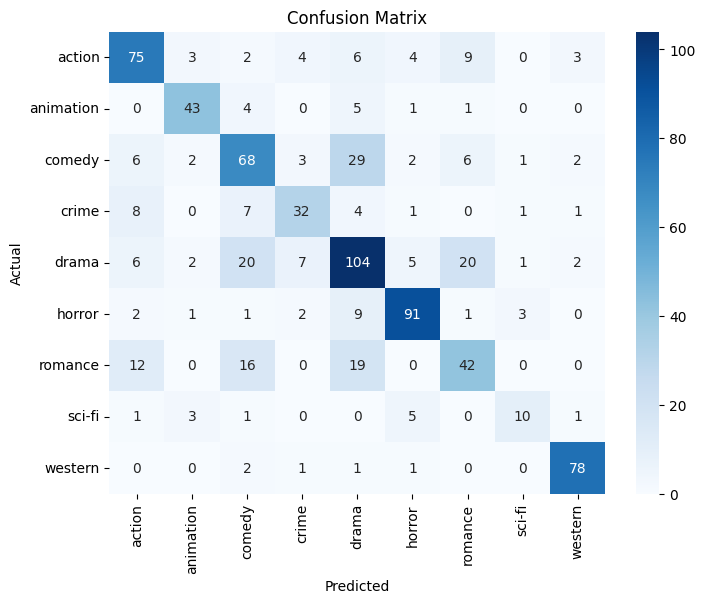

In [29]:
cm = cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, decoded_class_names)

### Scenario 5: HistGradientBoosting w/ Embeddings

In [ ]:
param_distributions = {
    "learning_rate": np.logspace(-3, 0, 100),
    "max_iter": np.arange(100, 500, 50),
    "max_depth": np.arange(3, 15),
    "min_samples_leaf": np.arange(1, 51, 5),
    "max_leaf_nodes": np.arange(10, 301, 10),
    "l2_regularization": np.logspace(-4, 0, 100),
    "scoring": ["accuracy"],
}

In [ ]:
random_search_5 = RandomizedSearchCV(
    HistGradientBoostingClassifier(),
    param_distributions=param_distributions,
    n_iter=50,
    scoring="accuracy",
    cv=4,
    verbose=4,
    random_state=42,
    n_jobs=-1,
)

random_search_5.fit(X_train, y_train)

In [ ]:
best_params = random_search_5.best_params_
best_score = random_search_5.best_score_
best_model = random_search_5.best_estimator_

print("\nBest Parameters:", best_params)
print("\nBest Score:", best_score)

Best parameters found: {
    
    'scoring': 'accuracy', 

    'min_samples_leaf': 6, 

    'max_leaf_nodes': 50, 

    'max_iter': 350, 

    'max_depth': 6, 

    'learning_rate': 0.1, 

    'l2_regularization': 0.0004430621457583882, 
    }
Best score found: 0.671883263271661

In [ ]:
# TODO: use best metrics to predict on test set
hgb = HistGradientBoostingClassifier()
hgb.set_params(**best_params)
hgb.fit(X_train, y_train)
y_pred = hgb.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, decoded_class_names)

# Predict Test Set

In [ ]:
path_test = "data/raw/test_no_labels.txt"
columns_test = ["title", "from", "director", "description"]

df_no_labels_test = read_data(path_test, columns_test)
df_no_labels_test.head(3)

In [ ]:
path_train = "data/raw/train.txt"
columns = ["title", "from", "genre", "director", "description"]

df = read_data(path, columns)
df.head(3)

In [ ]:
train_description = df["description"].dropna().unique()
test_description = df_no_labels_test["description"].dropna().unique()

overlapping_descriptions = set(train_description).intersection(set(test_description))
print(f"{len(overlapping_descriptions)} overlapping descriptions found.")

In [ ]:
rule_based_dict = df[df["description"].isin(overlapping_descriptions)].set_index("description")["genre"].to_dict()


def rule_based_prediction(description):
    if description in rule_based_dict:
        return rule_based_dict[description]
    return None


df_no_labels_test["rule_based_prediction"] = df_no_labels_test["description"].apply(rule_based_prediction)

df_no_labels_test[df_no_labels_test["description"].isin(overlapping_descriptions)].head(15)

In [ ]:
output_path = "data/processed/processed_embeddings_no_labels_test.csv"
process_and_save_in_chunks(df_no_labels_test, "description", model, chunk_size=300, output_path=output_path)